# 3: LegalBench Generation Evaluation (Pre-trained Self-RAG GGUF + EigenScore)

**Objective:** Compare generation methods on LegalBench-RAG benchmark using pre-trained Self-RAG 7B GGUF model

**Methods:**
1. **No-RAG**: Direct generation without retrieval (baseline)
2. **Basic RAG**: Retrieve once, then generate
3. **Self-RAG**: Adaptive retrieval with reflection tokens (token probability scoring)

**Model:** `selfrag_llama2_7b.Q4_K_M.gguf` (pre-trained on 150k examples)

**Metrics:**
- **F1 Score**: Token-level overlap with ground truth
- **ROUGE-L**: Longest common subsequence
- **EigenScore**: Semantic consistency-based hallucination detection (INSIDE, ICLR 2024)
- **Utility Score**: From ISUSE tokens (1-5)

**Key Design:** EigenScore is computed for ALL 3 methods as a universal hallucination metric.

In [7]:
import sys
from pathlib import Path
import json
import yaml
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Setup complete")

✓ Setup complete


## 1. Load Data and Models

In [8]:
# Load LegalBench mini dataset
QUERIES_FILE = "../data/legalbench-rag/queries.json"
NUM_QUERIES = 776  # Mini dataset

with open(QUERIES_FILE, 'r') as f:
    queries_data = json.load(f)

queries = queries_data['tests'][:NUM_QUERIES]

print(f"Loaded {len(queries)} queries")
print(f"\nExample query:")
print(f"  Query: {queries[0]['query'][:100]}...")
print(f"  Dataset: {queries[0]['dataset_source']}")
print(f"  Num snippets: {len(queries[0]['snippets'])}")

Loaded 776 queries

Example query:
  Query: Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate tha...
  Dataset: ContractNLI
  Num snippets: 1


In [9]:
# Count queries by subdataset
dataset_counts = defaultdict(int)
for q in queries:
    dataset_counts[q['dataset_source']] += 1

print("Queries by subdataset:")
for dataset, count in sorted(dataset_counts.items()):
    print(f"  {dataset}: {count}")

Queries by subdataset:
  ContractNLI: 776


### 1.1 Load Retriever

In [10]:
from retrieval.retriever import LegalRetriever
from retrieval.embedding import EmbeddingModel

# Load retriever
print("Loading retriever...")
embedding_model = EmbeddingModel(model_name="sentence-transformers/all-mpnet-base-v2")
retriever = LegalRetriever(embedding_model=embedding_model, top_k=3)
retriever.load_index("../data/legalbench_embeddings")

print("✓ Retriever loaded")

Loading retriever...
Loading embedding model: sentence-transformers/all-mpnet-base-v2
Model loaded on cpu
Embedding dimension: 768
Using CPU index
Created IndexFlatIP index with dimension 768
Index loaded from ../data/legalbench_embeddings/faiss_index.faiss
Total documents in index: 326783
Documents loaded from ../data/legalbench_embeddings/documents.pkl
✓ Retriever loaded


### 1.2 Load Self-RAG GGUF Model

Using the pre-trained Self-RAG 7B model converted to GGUF format (from notebook 2).
- **Model**: `selfrag_llama2_7b.Q4_K_M.gguf` (~4GB)
- **Inference**: llama.cpp with Metal acceleration
- **Embedding mode**: Enabled for INSIDE EigenScore computation

In [11]:
from self_rag.gguf_inference import (
    SelfRAGGGUFInference,
    SelfRAGOutput,
    compute_eigenscore,  # Standalone function for ANY method
    EIGENSCORE_THRESHOLD,
    DEFAULT_NUM_GENERATIONS,
)

# Path to GGUF model (from notebook 10)
MODEL_PATH = "../models/selfrag_llama2_7b.Q4_K_M.gguf"

# Check model exists
if not Path(MODEL_PATH).exists():
    print(f"⚠️  Model not found at {MODEL_PATH}")
    print("   Run notebook 10 first to download and convert the model.")
    raise FileNotFoundError(f"Model not found: {MODEL_PATH}")

# Load model (no embedding parameter - uses external encoder for INSIDE)
print("Loading Self-RAG GGUF model...")
inference = SelfRAGGGUFInference(
    model_path=MODEL_PATH,
    n_ctx=4096,  # Larger context to prevent KV cache overflow
    n_gpu_layers=-1,  # Use all layers on GPU (Metal)
)

print("✓ Model loaded successfully")
print(f"  EigenScore will be computed for ALL methods using external encoder")

Loading Self-RAG GGUF model...
Loading Self-RAG model: ../models/selfrag_llama2_7b.Q4_K_M.gguf


ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml

✓ Model loaded (persistent, single instance for all operations)
✓ Model loaded successfully
  EigenScore will be computed for ALL methods using external encoder


## 2. Individual Method Demonstrations (Exhibition)

This section demonstrates each generation method individually to show how they work.

**Methods:**
1. **No-RAG**: Direct generation without retrieval
2. **Basic RAG**: Retrieve once, then generate  
3. **Self-RAG**: Adaptive retrieval with reflection tokens

### Method 1: No-RAG (Baseline)

In [12]:
def no_rag_generation(query: str, inference: SelfRAGGGUFInference) -> dict:
    """
    Generate answer without retrieval (baseline).
    
    Uses GGUF model but explicitly skips retrieval.
    
    Args:
        query: Legal question
        inference: SelfRAGGGUFInference instance
    
    Returns:
        Dictionary with answer and metadata
    """
    # Generate without passage or retriever (forces no retrieval)
    result = inference.generate(
        question=query,
        passage=None,
        retriever=None,
        max_tokens=512,
        temperature=0.0,  # Deterministic
    )
    
    return {
        'answer': result.answer,
        'method': 'No-RAG',
        'num_tokens': len(result.answer.split()),
        'retrieve': result.retrieve,
        'isrel': result.isrel,
        'issup': result.issup,
        'isuse': result.isuse,
    }

# Test
test_result = no_rag_generation(queries[0]['query'], inference)
print("No-RAG test:")
print(f"  Answer: {test_result['answer'][:150]}...")
print(f"  Length: {test_result['num_tokens']} tokens")
print(f"  Tokens: retrieve={test_result['retrieve']}, isuse={test_result['isuse']}")

No-RAG test:
  Answer: It is not possible to determine the contents of a specific document without access to it.However, it is common for a non-disclosure agreement to state...
  Length: 102 tokens
  Tokens: retrieve=[No Retrieval], isuse=[Utility:5]


### Method 2: Basic RAG

In [13]:
# Shared configuration for number of passages to retrieve
TOP_K = 5  # Same K for both Basic RAG and Self-RAG multi-passage ranking

def basic_rag_generation(query: str, retriever, inference: SelfRAGGGUFInference, top_k: int = TOP_K) -> dict:
    """
    Generate answer with basic RAG (retrieve once, then generate).
    
    Always retrieves top passage and generates with it.
    
    Args:
        query: Legal question
        retriever: LegalRetriever instance
        inference: SelfRAGGGUFInference instance
        top_k: Number of passages to retrieve (uses top-1 for generation)
    
    Returns:
        Dictionary with answer and metadata
    """
    # Retrieve passages (using consistent K)
    retrieved_docs = retriever.retrieve(query, top_k=top_k)
    
    if not retrieved_docs:
        # Fallback to no-RAG if retrieval fails
        return no_rag_generation(query, inference)
    
    # Use top passage (Basic RAG always uses best match)
    top_passage = retrieved_docs[0]['text']
    
    # Generate with passage (forces retrieval)
    result = inference.generate(
        question=query,
        passage=top_passage,  # Explicitly provide passage
        retriever=None,
        max_tokens=512,
        temperature=0.0,
    )
    
    return {
        'answer': result.answer,
        'method': 'Basic RAG',
        'num_tokens': len(result.answer.split()),
        'retrieve': result.retrieve,
        'isrel': result.isrel,
        'issup': result.issup,
        'isuse': result.isuse,
        'retrieved_docs': [doc['text'][:50] + "..." for doc in retrieved_docs],
        'passage_score': retrieved_docs[0]['score'],
    }

# Test
test_result = basic_rag_generation(queries[0]['query'], retriever, inference)
print("Basic RAG test:")
print(f"  Answer: {test_result['answer'][:150]}...")
print(f"  Retrieved from: {test_result['retrieved_docs'][0]}")
print(f"  Tokens: isrel={test_result['isrel']}, issup={test_result['issup']}")

Basic RAG test:
  Answer: Yes, the Non-Disclosure Agreement between CopAcc and ToP Mentors does not grant the Receiving Party any rights to the Confidential Information....
  Retrieved from: 5.7 Title. As between the Parties, title or right ...
  Tokens: isrel=[Relevant], issup=[Fully supported]


### Method 3: Self-RAG (Multi-Passage Ranking)

Implements Self-RAG paper Section 3.3 ranking mechanism:
1. Retrieve K passages (same K as Basic RAG for fair comparison)
2. Generate one output per passage
3. Score each using weighted critique score: `S(Critique) = w_ISREL × s_ISREL + w_ISSUP × s_ISSUP + w_ISUSE × s_ISUSE`
4. Return best output by critique score

This is a simplified version (no beam search) but follows the paper's multi-passage ranking approach.

In [14]:
def self_rag_generation(query: str, retriever, inference: SelfRAGGGUFInference, top_k: int = TOP_K) -> dict:
    """
    Generate answer with Self-RAG multi-passage ranking (paper Section 3.3).
    
    Retrieves K passages, generates for each, ranks by critique score,
    and returns the best output.
    
    S(Critique) = w_ISREL × s_ISREL + w_ISSUP × s_ISSUP + w_ISUSE × s_ISUSE
    
    Args:
        query: Legal question
        retriever: LegalRetriever instance
        inference: SelfRAGGGUFInference instance
        top_k: Number of passages to retrieve and rank
    
    Returns:
        Dictionary with answer, reflection tokens, and metadata
    """
    # Use multi-passage ranking (paper Section 3.3)
    result = inference.generate_with_multi_passage_ranking(
        question=query,
        retriever=retriever,
        top_k=top_k,  # Same K as Basic RAG for fair comparison
    )
    
    output = result['output']
    
    return {
        'answer': output.answer,
        'method': 'Self-RAG',
        'num_tokens': len(output.answer.split()),
        'retrieve': output.retrieve,
        'isrel': output.isrel,
        'issup': output.issup,
        'isuse': output.isuse,
        'critique_score': result['critique_score'],
        'used_passage': result['used_passage'][:100] + "..." if result['used_passage'] else None,
        'passage_score': result['passage_score'],
        'num_candidates': len(result['all_candidates']),
    }

# # Test
# test_result = self_rag_generation(queries[0]['query'], retriever, inference)
# print("Self-RAG test (multi-passage ranking):")
# print(f"  Answer: {test_result['answer'][:150]}...")
# print(f"  Critique score: {test_result['critique_score']:.3f}")
# print(f"  Candidates ranked: {test_result['num_candidates']}")
# print(f"  Tokens: isrel={test_result['isrel']}, issup={test_result['issup']}, isuse={test_result['isuse']}")

## 3. Run Evaluation with Universal EigenScore

This section runs the full evaluation, computing **EigenScore** for ALL 3 methods.

**EigenScore** (INSIDE, ICLR 2024):
- Generates K responses with temperature sampling
- Computes semantic consistency via eigenvalue analysis
- Higher EigenScore = more diverse responses = higher hallucination risk

**Evaluation Process:**
1. For each query, generate K=10 responses per method
2. Compute EigenScore from response embeddings
3. Use first response for F1/ROUGE-L metrics

In [15]:
# Configuration
NUM_GENERATIONS = 6  # K for EigenScore computation

def evaluate_method(
    method_name: str,
    question: str,
    inference: SelfRAGGGUFInference,
    retriever,
    embedding_model,
    num_generations: int = NUM_GENERATIONS,
    top_k: int = TOP_K,  # Consistent retrieval K for both RAG methods
) -> dict:
    """
    Evaluate a single method with EigenScore hallucination detection.
    
    This unified function works for ALL methods and computes EigenScore
    as a universal hallucination metric.
    
    Args:
        method_name: 'No-RAG', 'Basic RAG', or 'Self-RAG'
        question: Input question
        inference: SelfRAGGGUFInference instance
        retriever: LegalRetriever instance
        embedding_model: EmbeddingModel for EigenScore computation
        num_generations: K generations for EigenScore
        top_k: Number of passages for RAG methods (consistent)
    
    Returns:
        Dictionary with answer, metrics, and EigenScore
    """
    if method_name == 'No-RAG':
        # Generate K responses without retrieval
        generations = inference.generate_multiple(
            question, passage=None, retriever=None,
            num_generations=num_generations
        )
        retrieved_docs = None
        critique_score = None
        
    elif method_name == 'Basic RAG':
        # Retrieve once with consistent K, then generate K responses with top passage
        retrieved_docs = retriever.retrieve(question, top_k=top_k)
        passage = retrieved_docs[0]['text'] if retrieved_docs else None
        generations = inference.generate_multiple(
            question, passage=passage, retriever=None,
            num_generations=num_generations
        )
        critique_score = None
        
    elif method_name == 'Self-RAG':
        # Self-RAG with multi-passage ranking (paper Section 3.3)
        # Use same K as Basic RAG for fair comparison
        ranking_result = inference.generate_with_multi_passage_ranking(
            question=question,
            retriever=retriever,
            top_k=top_k,  # Consistent with Basic RAG
        )
        best_output = ranking_result['output']
        critique_score = ranking_result['critique_score']
        retrieved_docs = None  # Retrieval handled internally
        
        # For EigenScore, generate additional responses using the selected passage
        if ranking_result['used_passage']:
            generations = inference.generate_multiple(
                question, 
                passage=ranking_result['used_passage'],
                retriever=None,
                num_generations=num_generations
            )
        else:
            generations = [best_output]  # Single generation if no passage
    
    else:
        raise ValueError(f"Unknown method: {method_name}")
    
    # Compute EigenScore from all K answers
    answers = [g.answer for g in generations]
    eigenscore, halluc_detected = compute_eigenscore(answers, embedding_model)
    
    # Use first generation for metrics (or best for Self-RAG)
    if method_name == 'Self-RAG':
        best_gen = best_output
    else:
        best_gen = generations[0]
    
    result = {
        'answer': best_gen.answer,
        'method': method_name,
        'num_tokens': len(best_gen.answer.split()),
        'eigenscore': eigenscore,
        'hallucination_detected': halluc_detected,
        'num_generations': len(generations),
    }
    
    # Add retrieval info for RAG methods
    if retrieved_docs:
        result['retrieved_docs'] = [doc['text'][:50] + "..." for doc in retrieved_docs]
        result['passage_score'] = retrieved_docs[0]['score']
    
    # Add critique score for Self-RAG
    if critique_score is not None:
        result['critique_score'] = critique_score
    
    return result

# # Test all 3 methods
# print("Testing all 3 methods with EigenScore:")
# print("=" * 60)

# for method in ['No-RAG', 'Basic RAG', 'Self-RAG']:
#     print(f"\n{method}:")
#     test_result = evaluate_method(
#         method, queries[0]['query'], inference, retriever, embedding_model,
#         num_generations=5  # Fewer for testing
#     )
#     print(f"  Answer: {test_result['answer'][:100]}...")
#     print(f"  EigenScore: {test_result['eigenscore']:.4f}")
#     print(f"  Hallucination detected: {test_result['hallucination_detected']}")

### 3.1 Configuration and Cache Management

In [16]:
# Configuration
USE_SUBSET = False  # Set to False to run on full 776 queries
SUBSET_SIZE = 10 if USE_SUBSET else len(queries)

# Cache file
CACHE_FILE = f"../results/generation_results_{'subset' if USE_SUBSET else 'full'}.json"
Path(CACHE_FILE).parent.mkdir(exist_ok=True)

print(f"Will evaluate on {SUBSET_SIZE} queries")
print(f"Cache file: {CACHE_FILE}")

Will evaluate on 776 queries
Cache file: ../results/generation_results_full.json


In [17]:
# Check if cached results exist. 
USE_CACHE = True
if USE_CACHE and Path(CACHE_FILE).exists():
    print(f"✓ Loading cached results from {CACHE_FILE}")
    with open(CACHE_FILE, 'r') as f:
        all_results = json.load(f)
    print(f"  Loaded {len(all_results)} results")
else:
    print("No cached results found or caching disabled. Will run evaluation...")
    all_results = None

✓ Loading cached results from ../results/generation_results_full.json
  Loaded 776 results


In [18]:
# Run evaluation (skip if cached). Spend about 850 minutes for full 776 × 4 methods.
if all_results is None:
    all_results = []
    
    # Use 4 generations for EigenScore computation
    EVAL_NUM_GENERATIONS = 4
    
    for i, query_data in enumerate(tqdm(queries[:SUBSET_SIZE], desc="Evaluating")):
        query = query_data['query']
        
        # Get ground truth
        if query_data['snippets']:
            ground_truth = query_data['snippets'][0]['answer']
        else:
            ground_truth = ""
        
        result_entry = {
            'query_id': i,
            'query': query,
            'ground_truth': ground_truth,
            'dataset_source': query_data['dataset_source'],
            'methods': {}
        }
        
        # Evaluate all 3 methods (with EigenScore for each)
        for method_name in ['No-RAG', 'Basic RAG', 'Self-RAG']:
            try:
                method_result = evaluate_method(
                    method_name=method_name,
                    question=query,
                    inference=inference,
                    retriever=retriever,
                    embedding_model=embedding_model,
                    num_generations=EVAL_NUM_GENERATIONS,
                )
                result_entry['methods'][method_name] = method_result
            except Exception as e:
                print(f"\nError in {method_name} for query {i}: {e}")
                result_entry['methods'][method_name] = {'error': str(e)}
        
        all_results.append(result_entry)
    
    # Save results
    with open(CACHE_FILE, 'w') as f:
        json.dump(all_results, f, indent=2, default=str)
    
    print(f"\n✓ Results saved to {CACHE_FILE}")

## 4. Compute Metrics

In [19]:
import re

# =============================================================================
# METRIC FUNCTIONS (Consolidated)
# =============================================================================

# --- Lexical Metrics ---
def compute_f1_score(prediction: str, ground_truth: str) -> float:
    """Compute token-level F1 score."""
    pred_tokens = set(prediction.lower().split())
    gt_tokens = set(ground_truth.lower().split())
    if not pred_tokens or not gt_tokens:
        return 0.0
    common = pred_tokens & gt_tokens
    precision = len(common) / len(pred_tokens) if pred_tokens else 0
    recall = len(common) / len(gt_tokens) if gt_tokens else 0
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

def compute_rouge_l(prediction: str, ground_truth: str) -> float:
    """Compute ROUGE-L score (longest common subsequence)."""
    pred_tokens = prediction.lower().split()
    gt_tokens = ground_truth.lower().split()
    if not pred_tokens or not gt_tokens:
        return 0.0
    m, n = len(pred_tokens), len(gt_tokens)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if pred_tokens[i-1] == gt_tokens[j-1]:
                dp[i][j] = dp[i-1][j-1] + 1
            else:
                dp[i][j] = max(dp[i-1][j], dp[i][j-1])
    lcs_len = dp[m][n]
    precision = lcs_len / len(pred_tokens) if pred_tokens else 0
    recall = lcs_len / len(gt_tokens) if gt_tokens else 0
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

# --- Categorical Accuracy (Yes/No/Not Mentioned) ---
def extract_answer_category(text: str) -> str:
    """Extract Yes/No/Not Mentioned category from model output."""
    if not text:
        return 'unknown'
    text_lower = text.lower().strip()
    has_yes = bool(re.search(r'\byes\b', text_lower))
    has_no = bool(re.search(r'\bno\b', text_lower))
    negation_patterns = [r'does not', r'doesn\'t', r'is not', r'isn\'t', r'cannot',
                         r'not mentioned', r'not stated', r'unclear']
    has_negation = any(re.search(p, text_lower) for p in negation_patterns)

    if text_lower.startswith('yes') or (has_yes and not has_no and not has_negation):
        return 'yes'
    elif text_lower.startswith('no') or has_negation or (has_no and not has_yes):
        return 'no'
    return 'unknown'

def compute_categorical_accuracy(predictions: list, ground_truths: list) -> dict:
    """Compute exact match accuracy for categorical answers."""
    correct = 0
    total = len(predictions)
    for pred, gt in zip(predictions, ground_truths):
        if extract_answer_category(pred) == extract_answer_category(gt):
            correct += 1
    return {'accuracy': correct / total if total > 0 else 0.0, 'correct': correct, 'total': total}

# --- Retrieval Metrics (Precision@k, Recall@k) ---
def compute_text_overlap(text1: str, text2: str) -> float:
    """Compute word-level Jaccard overlap between two texts."""
    if not text1 or not text2:
        return 0.0
    words1 = set(text1.lower().split())
    words2 = set(text2.lower().split())
    intersection = len(words1 & words2)
    union = len(words1 | words2)
    return intersection / union if union > 0 else 0.0

def compute_retrieval_precision_at_k(retrieved_docs: list, ground_truth_spans: list,
                                      k: int, overlap_threshold: float = 0.2) -> float:
    """Precision@k: Fraction of top-k retrieved docs containing relevant spans."""
    if not retrieved_docs or not ground_truth_spans:
        return 0.0
    top_k = retrieved_docs[:k]
    relevant_count = 0
    for doc in top_k:
        doc_text = doc if isinstance(doc, str) else doc.get('text', str(doc))
        for gt_span in ground_truth_spans:
            gt_text = gt_span.get('answer', '') if isinstance(gt_span, dict) else str(gt_span)
            if compute_text_overlap(doc_text, gt_text) >= overlap_threshold:
                relevant_count += 1
                break
    return relevant_count / k if k > 0 else 0.0

def compute_retrieval_recall_at_k(retrieved_docs: list, ground_truth_spans: list,
                                   k: int, overlap_threshold: float = 0.2) -> float:
    """Recall@k: Fraction of ground truth spans covered by top-k retrieved docs."""
    if not retrieved_docs or not ground_truth_spans:
        return 0.0
    top_k = retrieved_docs[:k]
    found_spans = 0
    for gt_span in ground_truth_spans:
        gt_text = gt_span.get('answer', '') if isinstance(gt_span, dict) else str(gt_span)
        for doc in top_k:
            doc_text = doc if isinstance(doc, str) else doc.get('text', str(doc))
            if compute_text_overlap(doc_text, gt_text) >= overlap_threshold:
                found_spans += 1
                break
    return found_spans / len(ground_truth_spans) if ground_truth_spans else 0.0

# --- Self-RAG Token Helpers ---
def extract_utility_score(isuse: str) -> int:
    """Extract utility score (1-5) from ISUSE token."""
    if not isuse:
        return 0
    match = re.search(r'(\d)', isuse)
    return int(match.group(1)) if match else 0

def is_hallucination_by_issup(issup: str) -> bool:
    """Check if ISSUP indicates no support (hallucination)."""
    if not issup:
        return False
    return 'No support' in issup or 'Contradictory' in issup

print("✓ All metric functions defined")

✓ All metric functions defined


In [20]:
# =============================================================================
# COMPUTE ALL METRICS (3 methods with universal EigenScore)
# =============================================================================

metrics_by_method = {}

for method_name in ['No-RAG', 'Basic RAG', 'Self-RAG']:
    f1_scores, rouge_scores = [], []
    eigenscores, halluc_by_eigen = [], []

    for result in all_results:
        if method_name not in result['methods'] or 'error' in result['methods'][method_name]:
            continue
        method_data = result['methods'][method_name]
        answer = method_data.get('answer', '')
        gt = result['ground_truth']

        # Lexical metrics
        f1_scores.append(compute_f1_score(answer, gt))
        rouge_scores.append(compute_rouge_l(answer, gt))

        # EigenScore (available for ALL methods now)
        if method_data.get('eigenscore') is not None:
            eigenscores.append(method_data['eigenscore'])
            halluc_by_eigen.append(method_data.get('hallucination_detected', False))

    metrics_by_method[method_name] = {
        'avg_f1_score': np.mean(f1_scores) if f1_scores else 0,
        'avg_rouge_l': np.mean(rouge_scores) if rouge_scores else 0,
        'avg_eigenscore': np.mean(eigenscores) if eigenscores else None,
        'hallucination_rate_eigen': np.mean(halluc_by_eigen) if halluc_by_eigen else None,
        'num_samples': len(f1_scores),
    }

# =============================================================================
# DISPLAY UNIFIED COMPARISON TABLE
# =============================================================================
import pandas as pd

comparison_data = []
for method_name, m in metrics_by_method.items():
    row = {
        'Method': method_name,
        'F1': f"{m['avg_f1_score']:.3f}",
        'ROUGE-L': f"{m['avg_rouge_l']:.3f}",
        'EigenScore': f"{m['avg_eigenscore']:.2f}" if m['avg_eigenscore'] is not None else 'N/A',
        'Halluc%': f"{m['hallucination_rate_eigen']*100:.0f}%" if m['hallucination_rate_eigen'] is not None else 'N/A',
        'N': m['num_samples'],
    }
    comparison_data.append(row)

print("=" * 80)
print("GENERATION METHOD COMPARISON (with Universal EigenScore)")
print("=" * 80)
print(pd.DataFrame(comparison_data).to_string(index=False))
print("=" * 80)
print(f"\nNote: EigenScore threshold = {EIGENSCORE_THRESHOLD}")
print("  Lower EigenScore = more consistent responses = lower hallucination risk")
print("\nMetrics:")
print("  - F1, ROUGE-L: Lexical overlap with ground truth")
print("  - EigenScore: Semantic consistency across K generations (INSIDE, ICLR 2024)")
print("  - Halluc%: Percentage flagged as hallucination by EigenScore")

GENERATION METHOD COMPARISON (with Universal EigenScore)
   Method    F1 ROUGE-L EigenScore Halluc%   N
   No-RAG 0.181   0.125      -0.75     99% 776
Basic RAG 0.223   0.156      -1.84     60% 776
 Self-RAG 0.219   0.157      -2.00     55% 776

Note: EigenScore threshold = -2.0
  Lower EigenScore = more consistent responses = lower hallucination risk

Metrics:
  - F1, ROUGE-L: Lexical overlap with ground truth
  - EigenScore: Semantic consistency across K generations (INSIDE, ICLR 2024)
  - Halluc%: Percentage flagged as hallucination by EigenScore


## 5. Visualizations

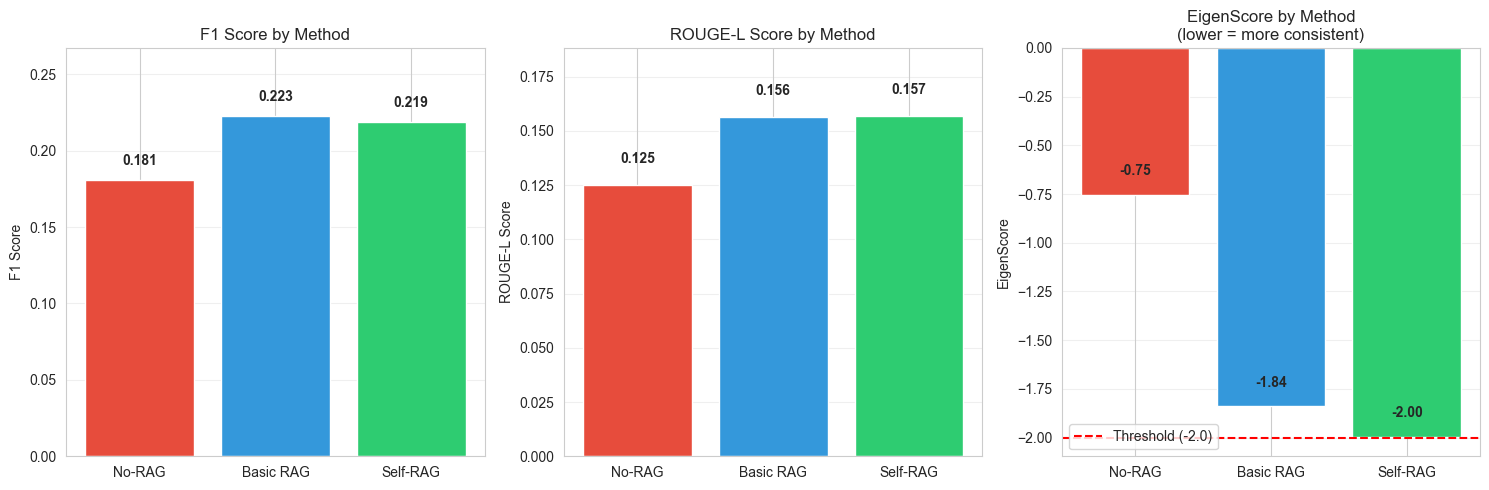

✓ Saved to results/generation_comparison.png


In [21]:
# Bar chart: F1, ROUGE-L, and EigenScore comparison (3 methods)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

methods = list(metrics_by_method.keys())
f1_scores = [metrics_by_method[m]['avg_f1_score'] for m in methods]
rouge_scores = [metrics_by_method[m]['avg_rouge_l'] for m in methods]

# Handle None EigenScores gracefully
eigenscores = []
for m in methods:
    es = metrics_by_method[m]['avg_eigenscore']
    if es is None:
        print(f"Warning: No EigenScore for {m}")
        eigenscores.append(0)
    else:
        eigenscores.append(es)

colors = ['#e74c3c', '#3498db', '#2ecc71']

# F1 scores
axes[0].bar(methods, f1_scores, color=colors)
axes[0].set_ylabel('F1 Score')
axes[0].set_title('F1 Score by Method')
axes[0].set_ylim(0, max(f1_scores) * 1.2 if f1_scores else 1)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(f1_scores):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# ROUGE-L scores
axes[1].bar(methods, rouge_scores, color=colors)
axes[1].set_ylabel('ROUGE-L Score')
axes[1].set_title('ROUGE-L Score by Method')
axes[1].set_ylim(0, max(rouge_scores) * 1.2 if rouge_scores else 1)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(rouge_scores):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# EigenScore (lower is better = more consistent)
axes[2].bar(methods, eigenscores, color=colors)
axes[2].set_ylabel('EigenScore')
axes[2].set_title('EigenScore by Method\n(lower = more consistent)')
axes[2].axhline(y=EIGENSCORE_THRESHOLD, color='red', linestyle='--', label=f'Threshold ({EIGENSCORE_THRESHOLD})')
axes[2].grid(axis='y', alpha=0.3)
axes[2].legend()
for i, v in enumerate(eigenscores):
    axes[2].text(i, v + 0.1, f'{v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/generation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved to results/generation_comparison.png")

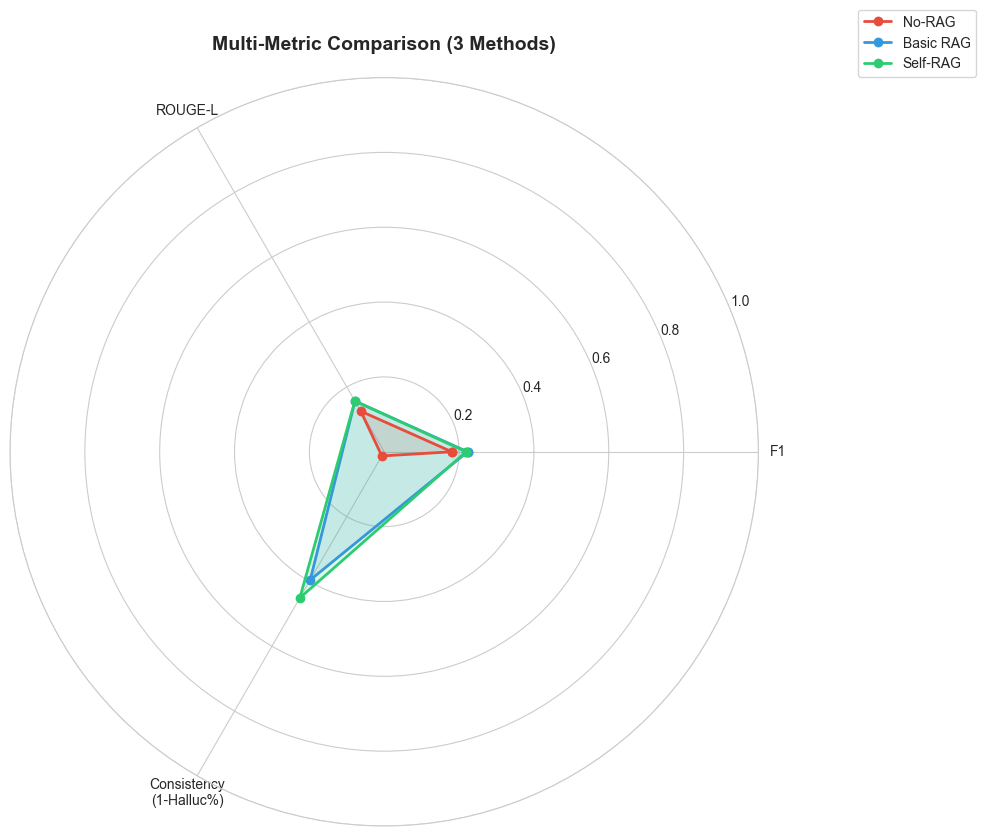

✓ Saved to results/radar_comparison.png


In [22]:
# Radar chart: Multi-metric comparison (3 methods)
from math import pi

# Prepare data (normalize to 0-1 for radar chart)
categories = ['F1', 'ROUGE-L', 'Consistency\n(1-Halluc%)']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors = ['#e74c3c', '#3498db', '#2ecc71']

for i, method in enumerate(methods):
    metrics = metrics_by_method[method]
    
    # Get hallucination rate from EigenScore (use actual values, not defaults)
    halluc_rate = metrics.get('hallucination_rate_eigen')
    if halluc_rate is None:
        # If no EigenScore data, show as "unknown" (0.5 consistency)
        consistency = 0.5
        print(f"Warning: No EigenScore data for {method}, using default consistency=0.5")
    else:
        consistency = 1 - halluc_rate
    
    values = [
        metrics['avg_f1_score'],
        metrics['avg_rouge_l'],
        consistency,
    ]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=method, color=colors[i])
    ax.fill(angles, values, alpha=0.15, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.set_title('Multi-Metric Comparison (3 Methods)', pad=20, fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/radar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved to results/radar_comparison.png")

## 6. Example Outputs

Show side-by-side comparison of the same query across all 3 methods.

In [23]:
# Pick an interesting example
example_idx = 5
example = all_results[example_idx]

# Use 3 methods (EigenScore is now computed for all)
methods_to_show = ['No-RAG', 'Basic RAG', 'Self-RAG']

print("=" * 100)
print(f"Example Query (ID: {example['query_id']})")
print("=" * 100)
print(f"Dataset: {example['dataset_source']}")
print()
print(f"Query: {example['query']}")
print()
print(f"Ground Truth: {example['ground_truth'][:300]}...")
print()
print("=" * 100)
print("Method Outputs (with Universal EigenScore)")
print("=" * 100)

for method_name in methods_to_show:
    if method_name not in example['methods']:
        continue
    
    method_data = example['methods'][method_name]
    
    if 'error' in method_data:
        print(f"\n{method_name}: ERROR - {method_data['error']}")
        continue
    
    answer = method_data.get('answer', '')
    
    # Compute metrics
    f1 = compute_f1_score(answer, example['ground_truth'])
    rouge = compute_rouge_l(answer, example['ground_truth'])
    
    print(f"\n{method_name}:")
    print(f"  F1: {f1:.3f} | ROUGE-L: {rouge:.3f}")
    
    # EigenScore (now available for ALL methods)
    if 'eigenscore' in method_data and method_data['eigenscore'] is not None:
        print(f"  EigenScore: {method_data['eigenscore']:.4f} | Halluc detected: {method_data['hallucination_detected']}")
    
    # Answer (truncated)
    print(f"  Answer: {answer[:200]}...")
    print("-" * 100)

Example Query (ID: 5)
Dataset: ContractNLI

Query: Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document require the Receiving Party to notify the Disclosing Party if they are required by law, regulation, or judicial process to disclose any Confidential Information?

Ground Truth: If Mentor is required by mandatory, non-appealable judicial or administrative process and/or order to disclose Confidential Information, then Mentor shall promptly notify Organiser and allow Organiser and the Participants reasonable time to oppose such process unless this is not admissible under a m...

Method Outputs (with Universal EigenScore)

No-RAG:
  F1: 0.133 | ROUGE-L: 0.074
  EigenScore: -1.0328 | Halluc detected: True
  Answer: It is not possible to say...
----------------------------------------------------------------------------------------------------

Basic RAG:
  F1: 0.377 | ROUGE-L: 0.195
  EigenScore: -1.2889 | Halluc detected: True
  Answer: Yes, the Non-Di

## 7. Summary and Analysis

### Model Configuration

- **Model**: `selfrag_llama2_7b.Q4_K_M.gguf` (pre-trained on 150k examples)
- **Inference**: llama.cpp with Metal acceleration
- **EigenScore**: Universal hallucination detection using external encoder (sentence-transformers)

### Method Comparison

| Method | Description | Retrieval | EigenScore |
|--------|-------------|-----------|------------|
| **No-RAG** | Generate without retrieval | None | Computed |
| **Basic RAG** | Retrieve top-k, generate with passage | Always | Computed |
| **Self-RAG** | Adaptive retrieval via token probability | Adaptive | Computed |

### Key Insights

1. **EigenScore as Universal Metric**: Now computed for ALL methods, enabling fair comparison of hallucination risk across generation approaches
2. **EigenScore Interpretation**: Higher EigenScore = more semantic diversity across K generations = model is less confident = higher hallucination risk
3. **Pre-trained model advantage**: Self-RAG 7B was trained on 150k examples - reflection tokens work out of the box

### EigenScore Implementation (refer to INSIDE, ICLR 2024)

- **Method**: Multi-generation (K=10) with temperature sampling
- **Embeddings**: External encoder (`sentence-transformers/all-mpnet-base-v2`)
- **Formula**: `EigenScore = mean(log(eigenvalues))` of covariance matrix
- **Intuition**: If model "knows" the answer, K generations will be similar (low EigenScore). If uncertain, generations will vary (high EigenScore).